In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+'data/bestfit_m_spec_J1226.pkl')
    d_spec = af.pickle_load(prefix+'data/d_spec_J1226.pkl')

    LogLike = af.pickle_load(prefix+'data/bestfit_LogLike_J1226.pkl')

    try:
        Cov = af.pickle_load(prefix+'data/bestfit_Cov.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+'data/bestfit_int_contr_em_J1226.npy')
    int_contr_em_per_order = np.load(prefix+'data/bestfit_int_contr_em_per_order_J1226.npy')
    int_opa_cloud          = np.load(prefix+'data/bestfit_int_opa_cloud_J1226.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [2]:
res = read_results(
    prefix='./retrieval_outputs/fiducial_J_B_ret_8/test_', n_params=29
)
posterior, bestfit, PT, Chem, _, _, _, m_spec, d_spec, LogLike, _, bestfit_params = res

pRT_atm = af.pickle_load(
    #'./retrieval_outputs/fiducial_J_B_ret_8/test_data/pRT_atm_broad_J1226.pkl'
    './retrieval_outputs/fiducial_J_B_ret_8/test_data/pRT_atm_J1226.pkl'
    )
pRT_atm.params = bestfit_params['params']


  analysing data from ./retrieval_outputs/fiducial_J_B_ret_8/test_.txt
(2463, 29)


In [3]:
_ = pRT_atm(Chem.mass_fractions, PT.temperature, bestfit_params['params'], get_contr=True, get_full_spectrum=False)

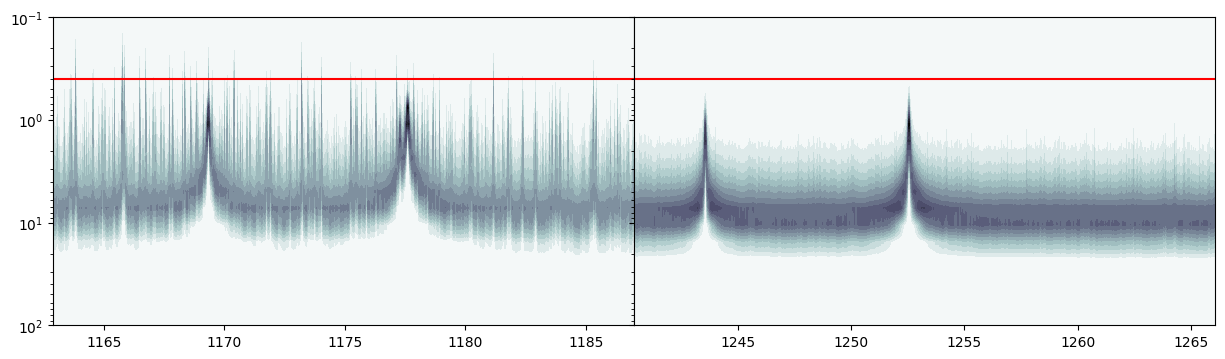

In [4]:
import petitRADTRANS.nat_cst as nc

fig, ax = plt.subplots(figsize=(15,4), ncols=2, sharey=True, gridspec_kw={'wspace':0.0})

order = 2
# Convert [cm] -> [nm]
m_wave = nc.c/pRT_atm.atm[order].freq * 1e7

X, Y = np.meshgrid(m_wave, PT.pressure)
ax[0].contourf(X, Y, pRT_atm.atm[order].contr_em, 15, cmap=plt.cm.bone_r)

order = 5
# Convert [cm] -> [nm]
m_wave = nc.c/pRT_atm.atm[order].freq * 1e7

X, Y = np.meshgrid(m_wave, PT.pressure)
ax[1].contourf(X, Y, pRT_atm.atm[order].contr_em, 15, cmap=plt.cm.bone_r)

for ax_i in ax:
    ax_i.axhline(10**(-0.4), c='r')

ax[0].set(yscale='log', ylim=(1e-1,1e2))
ax[0].invert_yaxis()

plt.savefig('./plots/K_lines_contr_em.pdf')
plt.show()

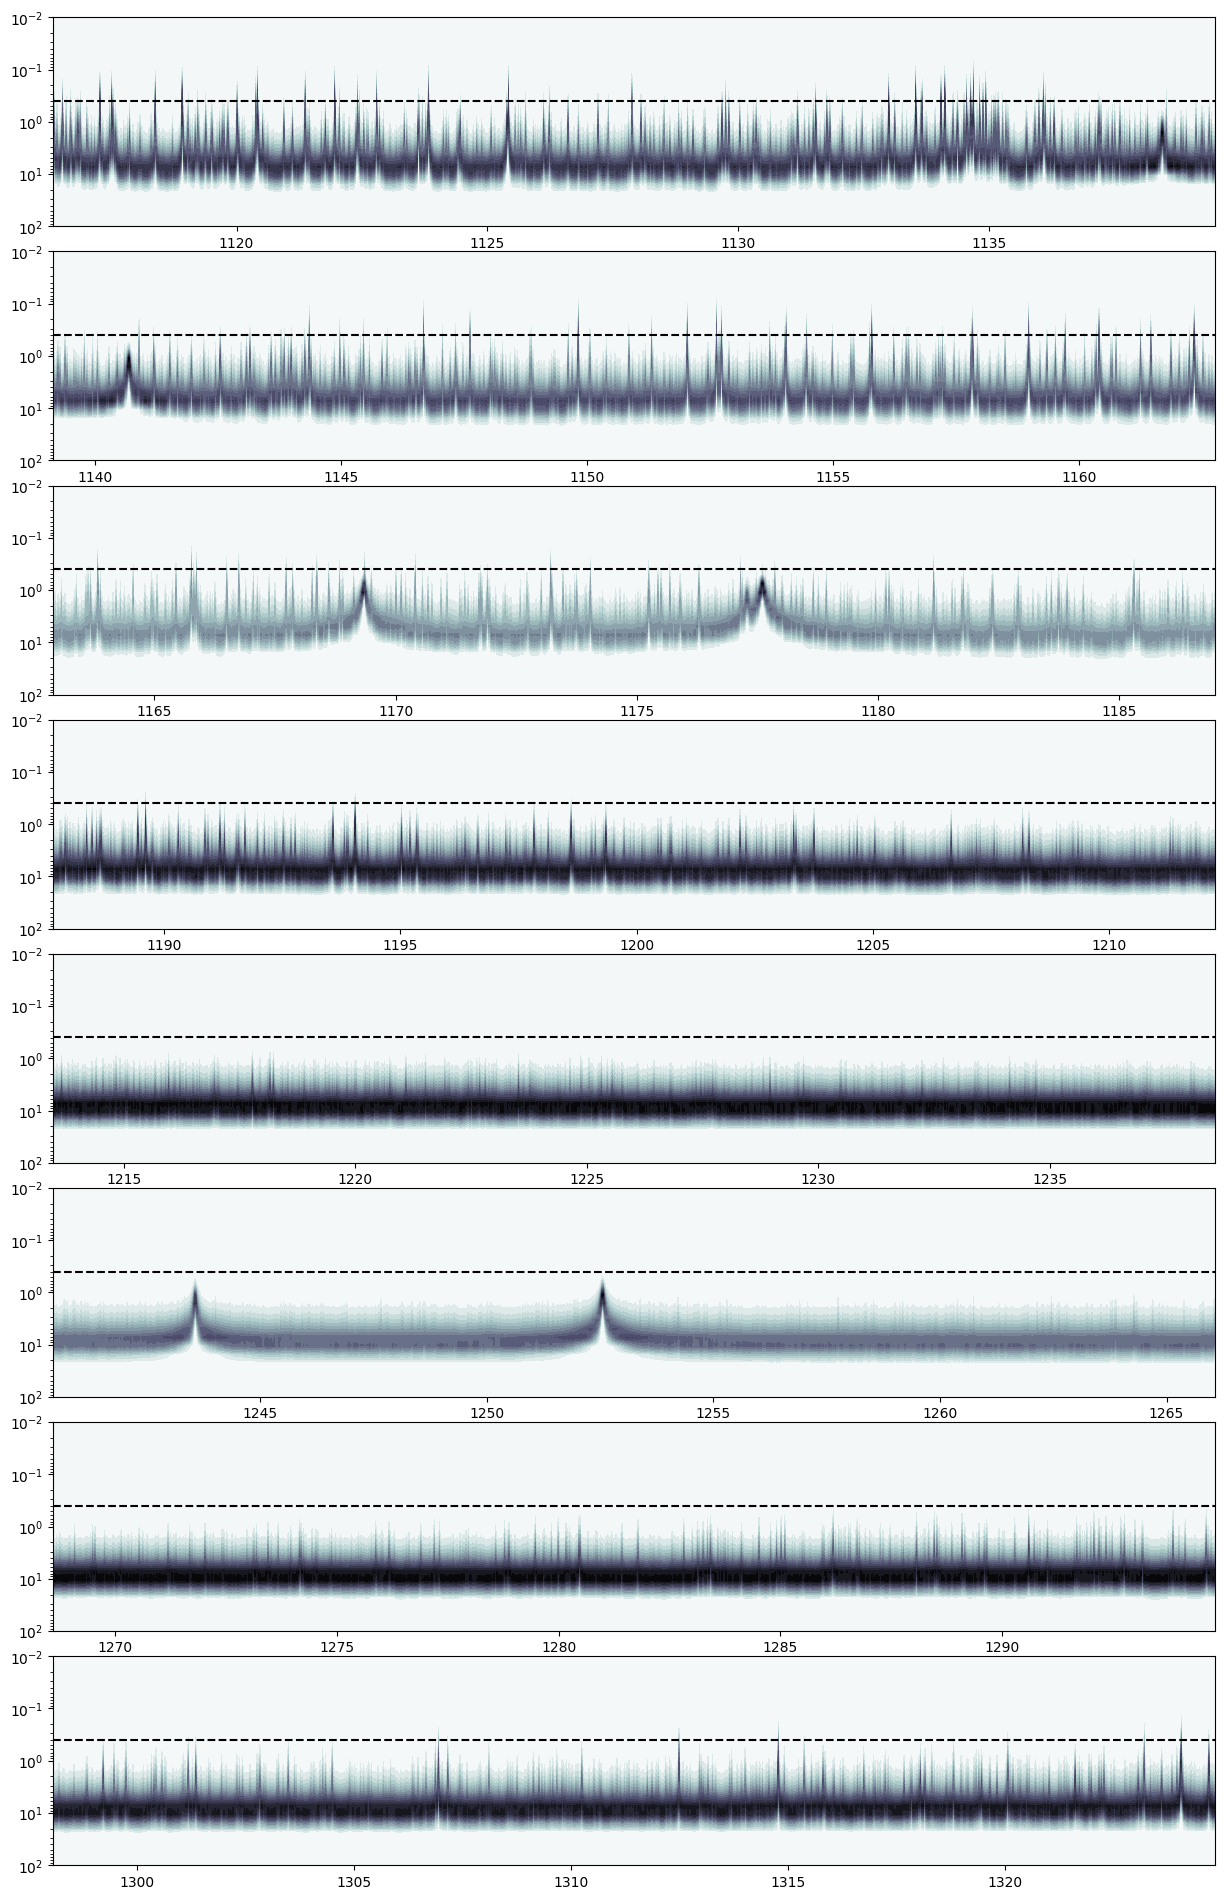

In [25]:
import petitRADTRANS.nat_cst as nc

fig, ax = plt.subplots(figsize=(15,3*d_spec.n_orders), nrows=d_spec.n_orders, sharey=True, gridspec_kw={'hspace':0.12})

for order in range(d_spec.n_orders):
    # Convert [cm] -> [nm]
    m_wave = nc.c/pRT_atm.atm[order].freq * 1e7

    X, Y = np.meshgrid(m_wave, PT.pressure)
    ax[order].contourf(X, Y, pRT_atm.atm[order].contr_em, 15, cmap=plt.cm.bone_r)

for ax_i in ax:
    ax_i.axhline(10**(-0.4), c='k', ls='--')

ax[0].set(yscale='log', ylim=(1e-2,1e2))
ax[0].invert_yaxis()

plt.savefig('./plots/K_lines_contr_em.pdf')
plt.show()

## Equilibrium VMR profiles

0.16200790699018433


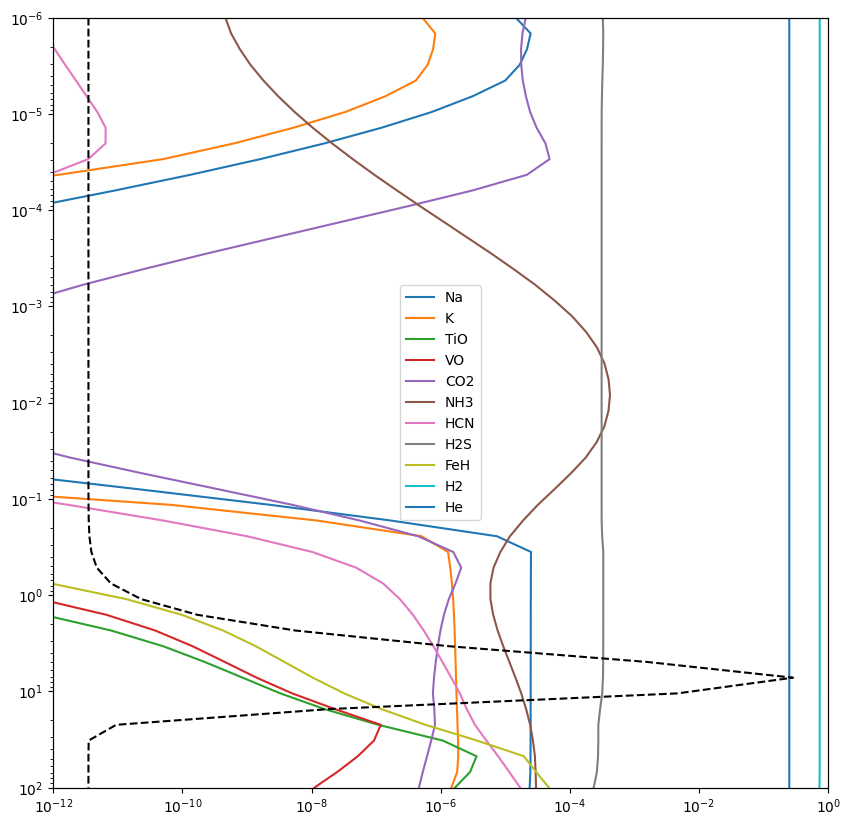

['H2',
 'He',
 'CO',
 'H2O',
 'HCN',
 'C2H2,acetylene',
 'CH4',
 'PH3',
 'CO2',
 'NH3',
 'H2S',
 'VO',
 'TiO',
 'Na',
 'K',
 'SiO',
 'e-',
 'H-',
 'H',
 'FeH',
 'MMW',
 'nabla_ad']

In [8]:
from petitRADTRANS import poor_mans_nonequ_chem as pm

pm_mass_fractions = pm.interpol_abundances(
    0.55*np.ones_like(PT.pressure), 0.0*np.ones_like(PT.pressure), 
    PT.temperature, PT.pressure
    )
print(np.mean(pm_mass_fractions['CH4']*16 + pm_mass_fractions['CO']*28 + pm_mass_fractions['H2O']*18))

fig, ax = plt.subplots(figsize=(10,10))

for species in ['Na', 'K', 'TiO', 'VO', 'CO2', 'NH3', 'HCN', 'H2S', 'FeH', 'H2', 'He']:
    ax.plot(pm_mass_fractions[species], PT.pressure, label=species)

ax.legend()
#ax.axhline(0.2, c='k', ls='--')

ax_contr = ax.twiny()
ax_contr.plot(pRT_atm.int_contr_em, PT.pressure, c='k', ls='--')
ax_contr.set(xticks=[])

ax.set(ylim=(1e-6,1e2), yscale='log', xlim=(1e-12,1e0), xscale='log')
ax.invert_yaxis()
plt.show()

list(pm_mass_fractions.keys())

## Cloud condensation

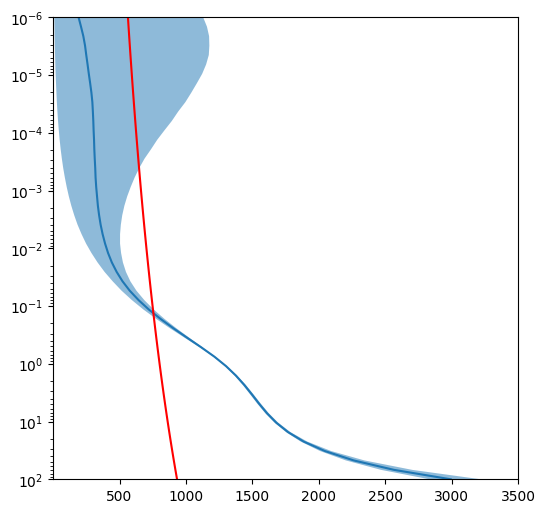

In [5]:
def cloud_condensation_curves(pressure, FeH, cloud_species):

    coeffs = {
        'CaTiO3': [5.125, -0.277, -0.554], # Wakeford et al. (2017)
        'Fe': [5.44, -0.48, -0.48], # Visscher et al. (2010)
        'Mg2SiO4': [5.89, -0.37, -0.73], # Visscher et al. (2010)
        'MgSiO3': [6.26, -0.35, -0.70], # Visscher et al. (2010)
        'Cr': [6.576, -0.486, -0.486], # Morley et al. (2012)
        'KCl': [12.479, -0.879, -0.879], # Morley et al. (2012)
        'MnS': [7.45, -0.42, -0.84], # Visscher et al. (2006)
        'Na2S': [10.05, -0.72, -1.08], # Visscher et al. (2006)
        'ZnS': [12.52, -0.63, -1.26], # Visscher et al. (2006)
        'H2S': [86.49, -8.54, -8.54], # Visscher et al. (2006)
    }

    a, b, c = coeffs[cloud_species]
    
    y = a + b*np.log10(pressure) + c*FeH
    T = 1e4/y

    return T

pressure = 10**np.linspace(-6,2,50)
T_cond = cloud_condensation_curves(pressure, 0, 'KCl')

fig, ax = plt.subplots(figsize=(6,6))
ax.fill_betweenx(pressure, PT.temperature_envelopes[1], PT.temperature_envelopes[-2], fc='C0', alpha=0.5, ec='none')
ax.plot(PT.temperature_envelopes[3], pressure, c='C0')
ax.plot(T_cond, pressure, c='r')
ax.set(yscale='log', ylim=(1e2,1e-6), xlim=(1,3500))
plt.show()

## Lorentzian fit to K I lines

[-0.05742522 -0.06069856]
[-13.8530792 -14.5377085]
[1243.59107113 1252.57483288]


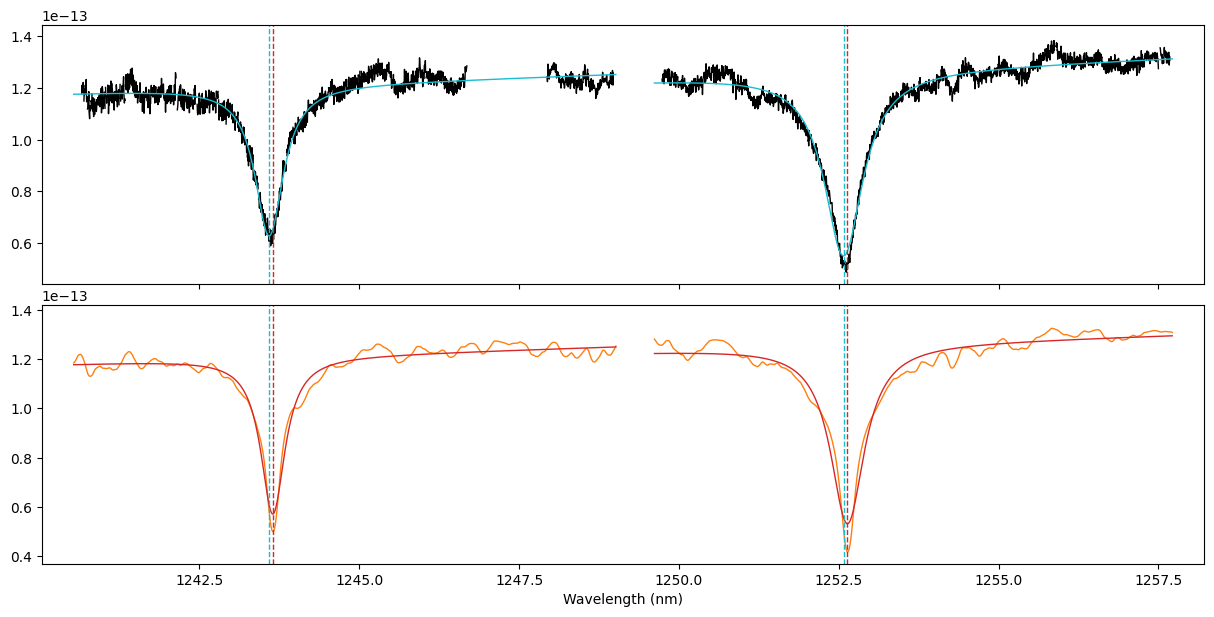

In [28]:
import petitRADTRANS.nat_cst as nc

fig, ax = plt.subplots(figsize=(15,7), nrows=2, sharex=True, gridspec_kw={'hspace':0.08})

order = 5
for j in range(d_spec.n_dets):
    ax[0].plot(d_spec.wave[order,j], d_spec.flux[order,j], c='k', lw=1)
    ax[1].plot(d_spec.wave[order,j], LogLike.f[order,j]*m_spec.flux[order,j], c='C1', lw=1)

from astropy.modeling.models import Lorentz1D, Linear1D, Const1D, Voigt1D
from astropy.modeling.fitting import LevMarLSQFitter

fit = LevMarLSQFitter()

s1_wave = np.arange(
    d_spec.wave[order].min()-0.5, d_spec.wave[order].max()+0.5, 
    np.diff(d_spec.wave[order].flatten())[0]
    )

s1 = Lorentz1D(amplitude=-1e-13, x_0=1243.6, fwhm=0.7) + \
    Linear1D(slope=1e-15, intercept=-1.1e-12) + \
    Const1D(0)
s = fit(
    s1, d_spec.wave[order,0], LogLike.f[order,0]*m_spec.flux[order,0]
    )
ax[1].plot(d_spec.wave[order,0], s(d_spec.wave[order,0]), c='C3', lw=1)
K_I_pRT = [s.x_0_0.value]

s1 = Lorentz1D(amplitude=-1e-13, x_0=1252.6, fwhm=0.7) + \
    Linear1D(slope=1e-15, intercept=-1.1e-12) + \
    Const1D(0)
s = fit(
    s1, d_spec.wave[order,1], LogLike.f[order,1]*m_spec.flux[order,1]
    )
ax[1].plot(d_spec.wave[order,1], s(d_spec.wave[order,1]), c='C3', lw=1)
K_I_pRT.append(s.x_0_0.value)

########################################################################
s1 = Lorentz1D(amplitude=-1e-13, x_0=1243.6, fwhm=0.7) + \
    Linear1D(slope=1e-15, intercept=-1.1e-12) + \
    Const1D(0)
s = fit(
    s1, d_spec.wave[order,0][d_spec.mask_isfinite[order,0]], 
    d_spec.flux[order,0][d_spec.mask_isfinite[order,0]]
    )
ax[0].plot(d_spec.wave[order,0], s(d_spec.wave[order,0]), c='C9', lw=1)
K_I_obs = [s.x_0_0.value]

s1 = Lorentz1D(amplitude=-1e-13, x_0=1252.6, fwhm=0.7) + \
    Linear1D(slope=1e-15, intercept=-1.1e-12) + \
    Const1D(0)
s = fit(
    s1, d_spec.wave[order,1][d_spec.mask_isfinite[order,1]], 
    d_spec.flux[order,1][d_spec.mask_isfinite[order,1]]
    )
ax[0].plot(d_spec.wave[order,1], s(d_spec.wave[order,1]), c='C9', lw=1)
K_I_obs.append(s.x_0_0.value)

K_I_obs = np.array(K_I_obs)
K_I_pRT = np.array(K_I_pRT)
print((K_I_obs-K_I_pRT))
print((K_I_obs-K_I_pRT)/K_I_obs * 3e5)
print(K_I_obs)

for ax_i in ax:
    for line in K_I_obs:
        ax_i.axvline(line, c='C9', ls='--', lw=1)
    for line in K_I_pRT:
        ax_i.axvline(line, c='C3', ls='--', lw=1)

ax[1].set(
    xlabel=r'Wavelength (nm)', 
    xlim=(d_spec.wave[order,0].min()-0.5, d_spec.wave[order,1].max()+0.5)
    )

plt.savefig('./plots/K_lines_fit.pdf')
plt.show()

## Changing potassium VMR profile

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.50664502e-07 6.50664502e-07
 6.50664502e-07 6.50664502e-07 6.50664502e-07 6.50664502e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


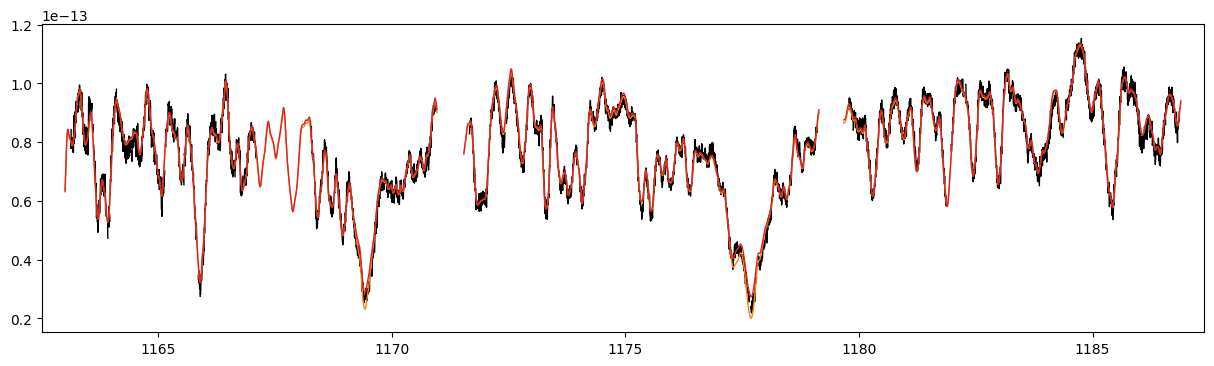

In [34]:
import petitRADTRANS.nat_cst as nc

fig, ax = plt.subplots(figsize=(15,4), ncols=1)

Chem.mass_fractions['K'] = np.ones_like(Chem.mass_fractions['K'])*6.50664502e-07
m_spec = pRT_atm(Chem.mass_fractions, PT.temperature, bestfit_params['params'], get_contr=True, get_full_spectrum=False)

order = 2
for j in range(d_spec.n_dets):
    ax.plot(d_spec.wave[order,j], d_spec.flux[order,j], c='k', lw=1)

for j in range(d_spec.n_dets):
    ax.plot(d_spec.wave[order,j], LogLike.f[order,j]*m_spec.flux[order,j], c='C1', lw=1)


mask_pressure = (np.log10(PT.pressure) < 0.2)
#mask_pressure = (np.log10(PT.pressure) < 0.05)
Chem.mass_fractions['K'][mask_pressure] = 0

mask_pressure = (np.log10(PT.pressure) > 1.08)
Chem.mass_fractions['K'][mask_pressure] = 0
print(Chem.mass_fractions['K'])
m_spec = pRT_atm(Chem.mass_fractions, PT.temperature, bestfit_params['params'], get_contr=True, get_full_spectrum=False)

for j in range(d_spec.n_dets):
    ax.plot(d_spec.wave[order,j], LogLike.f[order,j]*m_spec.flux[order,j], c='C3', lw=1)

ax.set(xlim=(d_spec.wave[order,0].min()-0.5, d_spec.wave[order,2].max()+0.5))

#plt.savefig('./plots/K_lines_contr_em.pdf')
plt.show()